In [65]:
import pandas as pd
pd.options.display.max_columns = None
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')
%matplotlib inline

In [4]:
train = pd.read_csv('input/train.csv')
test = pd.read_csv('input/test.csv')

train['is_train'] = True
test['is_train'] = False

print("length of training set = {:d} observations".format(len(train)))
print("length of testing set = {:d} observations".format(len(test)))

data = pd.concat((train,test)).reset_index(drop=True)

assert len(data) == len(train) + len(test)
print("correctly concatenated train and test data  =>  num. observations = {:d}".format(len(data)))

data_features = data.drop(['Response', 'is_train'], axis=1)

length of training set = 59381 observations
length of testing set = 19765 observations
correctly concatenated train and test data  =>  num. observations = 79146


## List the features that have null values:

In [5]:
features_with_nulls = {k:v for k, v in data_features.isnull().apply(sum).to_dict().items() if v > 0}
features_with_nulls

{'Employment_Info_1': 22,
 'Employment_Info_4': 8916,
 'Employment_Info_6': 14641,
 'Family_Hist_2': 38536,
 'Family_Hist_3': 45305,
 'Family_Hist_4': 25861,
 'Family_Hist_5': 55435,
 'Insurance_History_5': 33501,
 'Medical_History_1': 11861,
 'Medical_History_10': 78388,
 'Medical_History_15': 59460,
 'Medical_History_24': 74165,
 'Medical_History_32': 77688}

In [81]:
def loosen_limits(ax, which='x'):
    if which == 'x' or which == 'xy':
        x0, x1 = ax.get_xlim()
        xr = x1 - x0
        ax.set_xlim(x0 - 0.05 *xr, x1 + 0.05 * xr)
    elif  which == 'y' or which == 'xy':
        y0, y1 = ax.get_ylim()
        yr = y1 - y0
        ax.set_ylim(y0 - 0.05 *yr, y1 + 0.05 * yr)
    
def make_hist(df, cols, ylog=False):
    ysize = (len(cols) // 5 + 1) * 3.
    ax = df[cols].hist(figsize=(16,ysize), bins=50, sharex=False, layout=(-1,5))
    for axes in ax.flat:
        loosen_limits(axes)
        name = axes.get_title()
        if name == '':
            continue
        
        axes.set_title("{} [{:d}]".format(name, df[name].count()), fontsize=10)
        if ylog:
            axes.set_yscale('log')
        
def make_hexbin(df, col):
    ax = df.plot(kind='hexbin', x=col, y='Response', sharex=False, gridsize=25, norm=matplotlib.colors.PowerNorm(1/2))
    ax.set_ylim(0., 9)
    loosen_limits(ax)
    ax.set_title(col, fontsize=10)
    return ax

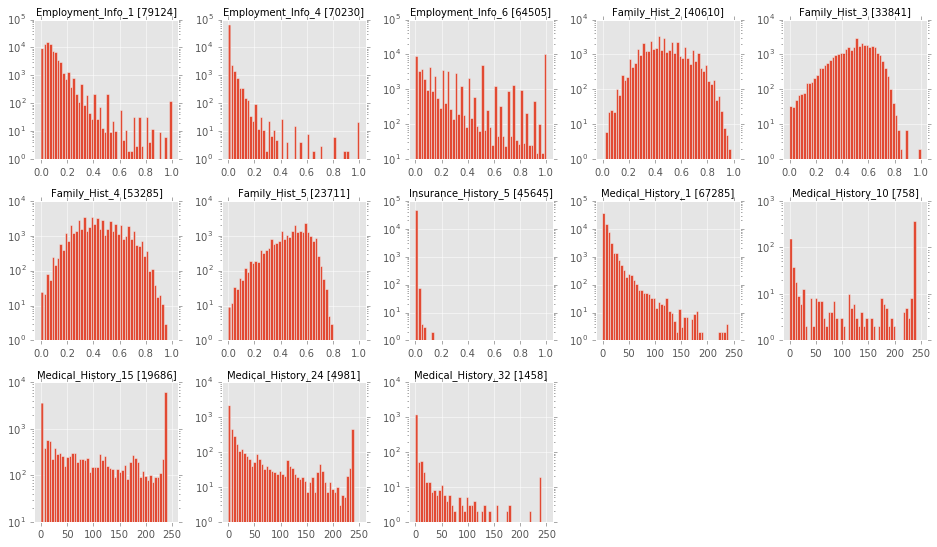

In [82]:
na_cols = list(features_with_nulls.keys())
make_hist(data_features, na_cols, ylog=True)

# Analyze each of the features that have null values


## Employment_Info 1, 4, 6 

These ones will be imputed with median value, since there are not that many NAs

## Family_Hist 2, 3, 4, 5 

These ones will be imputed with the median, and a new isNA? dummy column will be created for each.   Will do this since the number of NAs is a good fraction of the total data. 

## Insurance_History_5

This one is examined in more detail below.  It will be dropped from the analysis. 

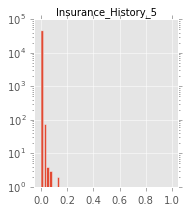

In [60]:
make_hist(data_features, ['Insurance_History_5'], ylog=True)

In [61]:
data_features['Insurance_History_5'].describe()

count    45645.000000
mean         0.001710
std          0.006465
min          0.000000
25%          0.000400
50%          0.000933
75%          0.002000
max          1.000000
Name: Insurance_History_5, dtype: float64

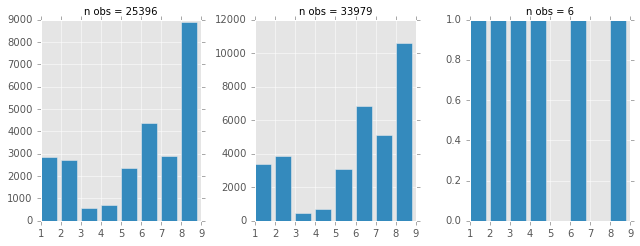

In [97]:
nulls = train[train['Insurance_History_5'].isnull()]['Response']
lo = train[train['Insurance_History_5'] < 0.05]['Response']
hi = train[train['Insurance_History_5'] >= 0.05]['Response']

fig, ax = plt.subplots(1,3, figsize=(9., 3.5))
for i,s in enumerate([nulls, lo, hi]):
    cts = s.value_counts()
    ax[i].bar(cts.index, cts.values)
    ax[i].set_title("n obs = {:d}".format(len(s)), fontsize=10)
fig.tight_layout()


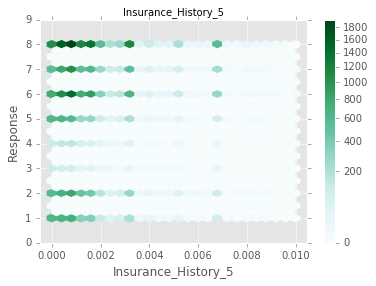

In [47]:
make_hexbin(train[train['Insurance_History_5'] < 0.01], 'Insurance_History_5')

Conclusion, will drop this feature from the data

## Medical_History_1 

Will be imputed with median

## Medical_History_10

This one will be converted into three dummy variables: 

1. is null?
2. is not null and < 200?
3. is not null and >= 200?


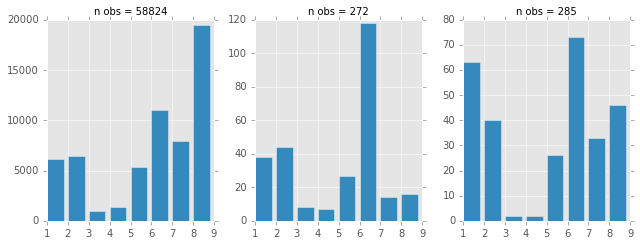

In [105]:
nulls = train[train['Medical_History_10'].isnull()]['Response']
nonull1 = train[(~train['Medical_History_10'].isnull()) & (train['Medical_History_10'] < 200) ]['Response']
nonull2 = train[(~train['Medical_History_10'].isnull()) & (train['Medical_History_10'] >= 200) ]['Response']

fig, ax = plt.subplots(1,3, figsize=(9., 3.5))
for i,s in enumerate([nulls, nonull1, nonull2]):
    cts = s.value_counts()
    ax[i].bar(cts.index, cts.values)
    ax[i].set_title("n obs = {:d}".format(len(s)), fontsize=10)
fig.tight_layout()

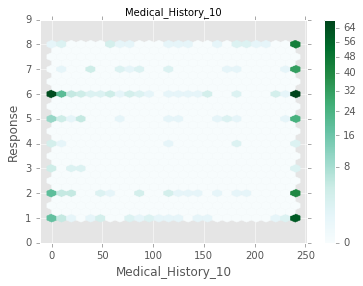

In [98]:
make_hexbin(train[~train['Medical_History_10'].isnull()], 'Medical_History_10')

## Medical_History_15

This one will be replaced with 4 dummies: 

1.  is null?
2.  not null and < 12
3.  not null and >=12 and < 200 
4.  not null and >= 200 

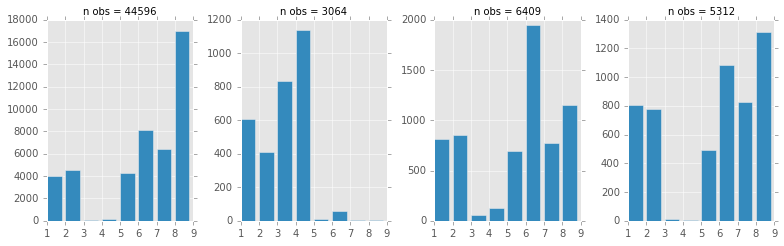

In [124]:
nulls = train[train['Medical_History_15'].isnull()]['Response']
nonull0 = train[(~train['Medical_History_15'].isnull()) &
                (train['Medical_History_15']< 12)]['Response']
nonull1 = train[(~train['Medical_History_15'].isnull()) &
                (train['Medical_History_15'] >= 12) &
                (train['Medical_History_15'] < 200) ]['Response']
nonull2 = train[(~train['Medical_History_15'].isnull()) & (train['Medical_History_15'] >= 200) ]['Response']

fig, ax = plt.subplots(1,4, figsize=(11., 3.5))
for i,s in enumerate([nulls, nonull0, nonull1, nonull2]):
    cts = s.value_counts()
    ax[i].bar(cts.index, cts.values)
    ax[i].set_title("n obs = {:d}".format(len(s)), fontsize=10)
fig.tight_layout()

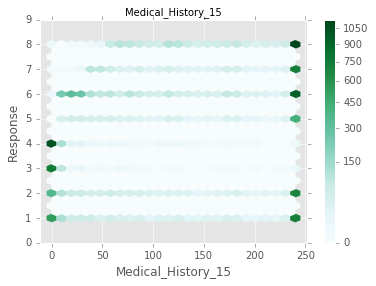

In [107]:
make_hexbin(train[~train['Medical_History_15'].isnull()], 'Medical_History_15')

## Medical_History 24

This one will be replaced with 3 dummies:

1. is null?
2. not null and < 25
3. not null and >= 25

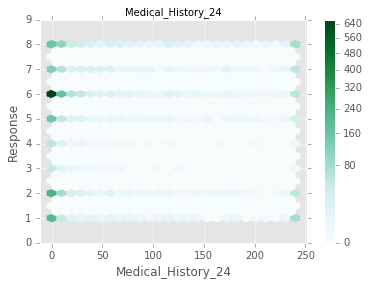

In [125]:
make_hexbin(train[~train['Medical_History_24'].isnull()], 'Medical_History_24')

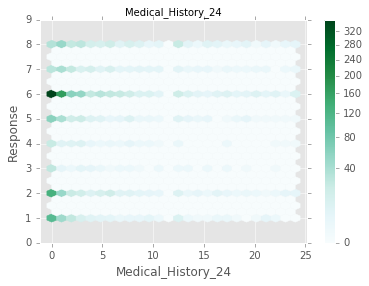

In [131]:
make_hexbin(train[train['Medical_History_24'] < 25], 'Medical_History_24')

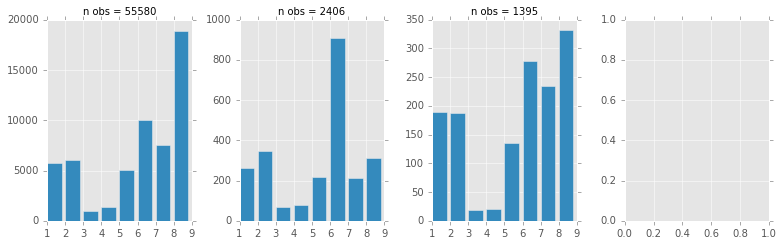

In [130]:
name = 'Medical_History_24'

nulls = train[train[name].isnull()]['Response']
nonull0 = train[(~train[name].isnull()) &
                (train[name]< 25)]['Response']
nonull1 = train[(~train[name].isnull()) &
                (train[name] >= 25)]['Response']

fig, ax = plt.subplots(1,4, figsize=(11., 3.5))
for i,s in enumerate([nulls, nonull0, nonull1]):
    cts = s.value_counts()
    ax[i].bar(cts.index, cts.values)
    ax[i].set_title("n obs = {:d}".format(len(s)), fontsize=10)
fig.tight_layout()

## Medical_History_32

This one will be replaced with 3 dummies:

1. is null?
2. not null and < 100
3. not null and >= 100

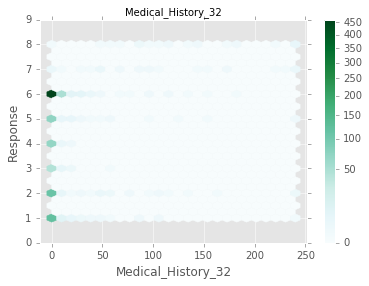

In [132]:
make_hexbin(train[~train['Medical_History_32'].isnull()], 'Medical_History_32')

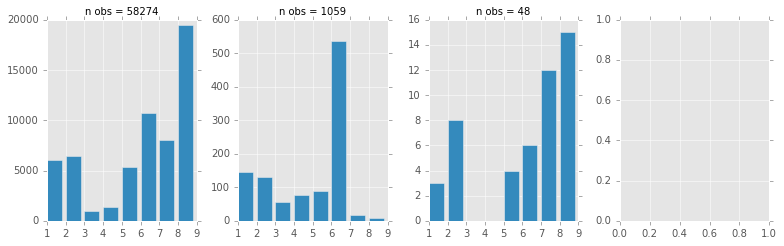

In [134]:
name = 'Medical_History_32'

nulls = train[train[name].isnull()]['Response']
nonull0 = train[(~train[name].isnull()) &
                (train[name]< 100)]['Response']
nonull1 = train[(~train[name].isnull()) &
                (train[name] >= 100)]['Response']

fig, ax = plt.subplots(1,4, figsize=(11., 3.5))
for i,s in enumerate([nulls, nonull0, nonull1]):
    cts = s.value_counts()
    ax[i].bar(cts.index, cts.values)
    ax[i].set_title("n obs = {:d}".format(len(s)), fontsize=10)
fig.tight_layout()

In [67]:
df = pd.read_csv('csvs/data_imputed.csv')
train = df[df['train?']].drop('Id', axis=1)

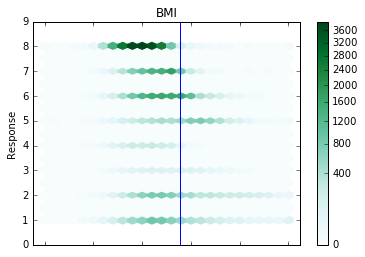

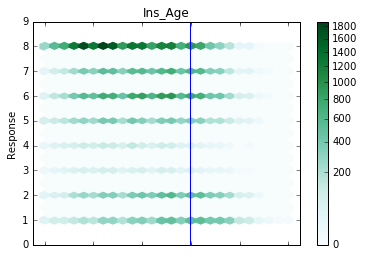

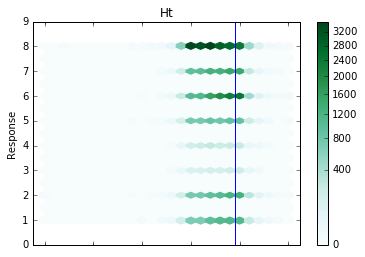

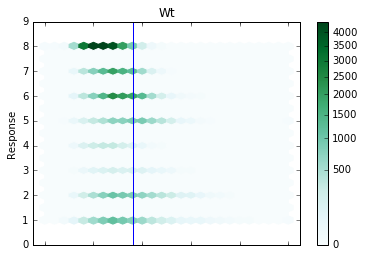

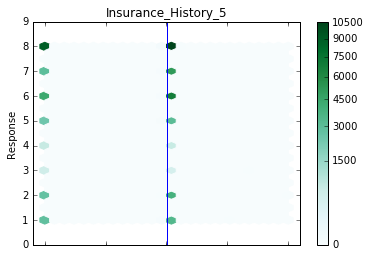

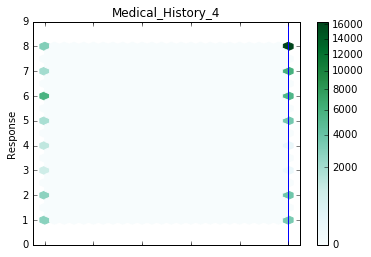

In [27]:
for name in ['BMI', 'Ins_Age', 'Ht', 'Wt', 'Insurance_History_5', 'Medical_History_4']:
    ax = train.plot(kind='hexbin', x=name, y='Response', gridsize=25, norm=matplotlib.colors.PowerNorm(1/2))
    ax.set_ylim(0., 9)
    xlim0, xlim1 = ax.get_xlim()
    xr = xlim1 - xlim0
    ax.set_xlim(xlim0 - xr*0.05, xlim1 + xr*0.05)
    ax.set_title(name)
    qcut = train[name].quantile(0.80)
    ax.axvline(qcut)

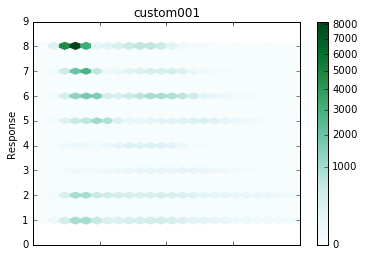

In [34]:
name = 'custom001'
try:
    train = train.drop(name, axis=1)
except ValueError:
    pass
new= train['BMI'] * (0.4)**train['Medical_History_4']
new.name = name
train = train.join(new)

ax = train.plot(kind='hexbin', x=name, y='Response', gridsize=25, norm=matplotlib.colors.PowerNorm(1/2))
ax.set_ylim(0., 9)
ax.set_title(name)

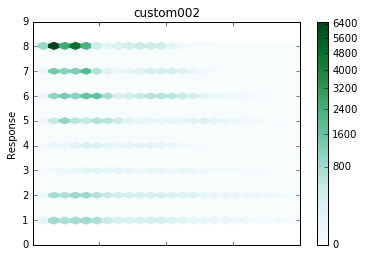

In [40]:
name = 'custom002'
try:
    train = train.drop(name, axis=1)
except ValueError:
    pass
new= train['BMI'] * (2.0)**train['Insurance_History_5'] * (0.4)**train['Medical_History_4']
new.name = name
train = train.join(new)

ax = train.plot(kind='hexbin', x=name, y='Response', gridsize=25, norm=matplotlib.colors.PowerNorm(1/2))
ax.set_ylim(0., 9)
ax.set_title(name)

In [ ]:
name = 'custom002'
try:
    train = train.drop(name, axis=1)
except ValueError:
    pass
new= train['BMI'] * train['Ins_Age']**2.
new.name = name
train = train.join(new)

ax = train.plot(kind='hexbin', x=name, y='Response', gridsize=25, norm=matplotlib.colors.PowerNorm(1/2))
ax.set_ylim(0., 9)
ax.set_title(name)

In [42]:
it = iter(train.columns)
while True:
    it

AttributeError: 'iterator' object has no attribute 'take'

In [43]:
it = iter(train.columns)

In [73]:
for axis in ax.flat:
    print(axis)

Axes(0.125,0.741837;0.215278x0.158163)
Axes(0.404861,0.741837;0.215278x0.158163)
Axes(0.684722,0.741837;0.215278x0.158163)
Axes(0.125,0.536224;0.215278x0.158163)
Axes(0.404861,0.536224;0.215278x0.158163)
Axes(0.684722,0.536224;0.215278x0.158163)
Axes(0.125,0.330612;0.215278x0.158163)
Axes(0.404861,0.330612;0.215278x0.158163)
Axes(0.684722,0.330612;0.215278x0.158163)
Axes(0.125,0.125;0.215278x0.158163)
Axes(0.404861,0.125;0.215278x0.158163)
Axes(0.684722,0.125;0.215278x0.158163)


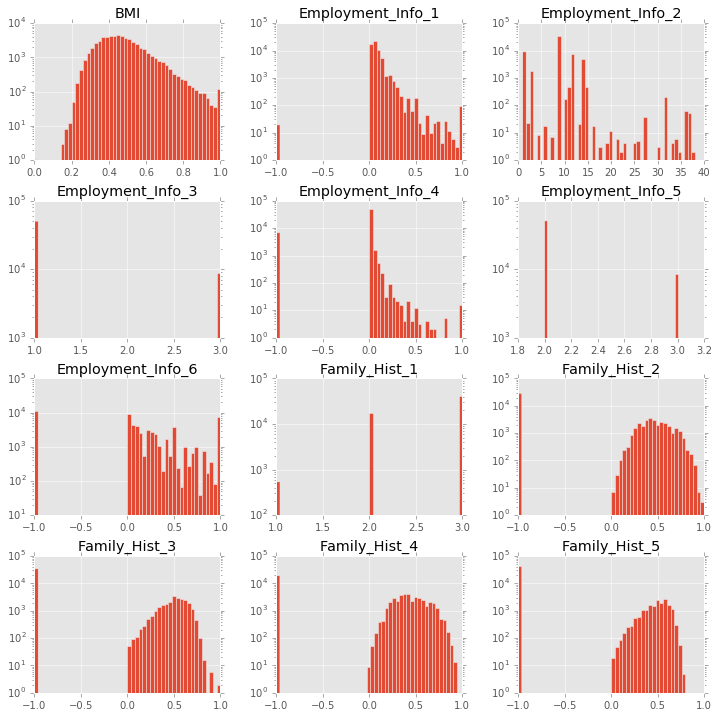

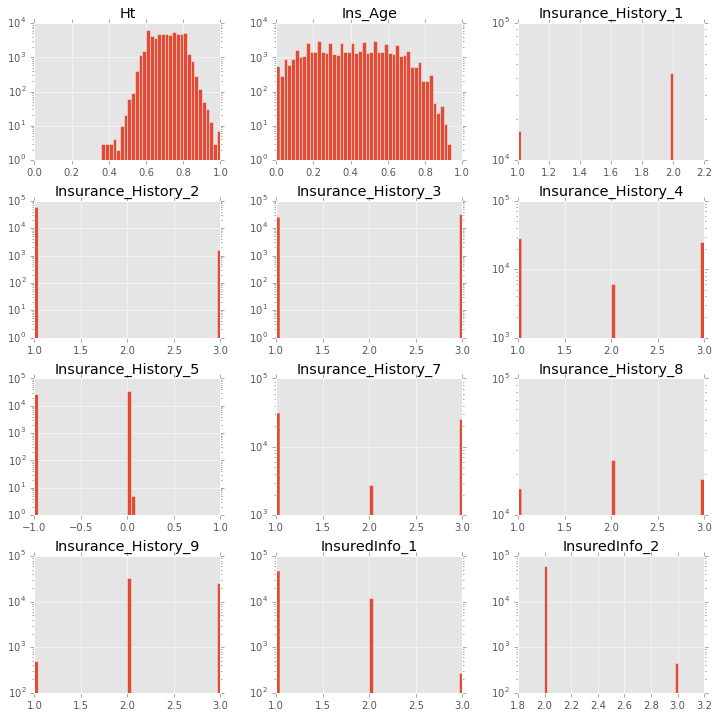

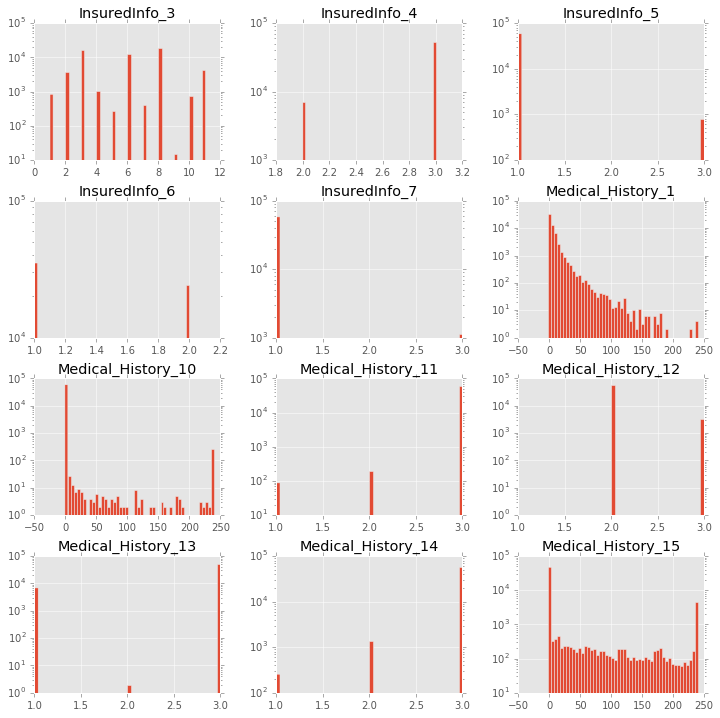

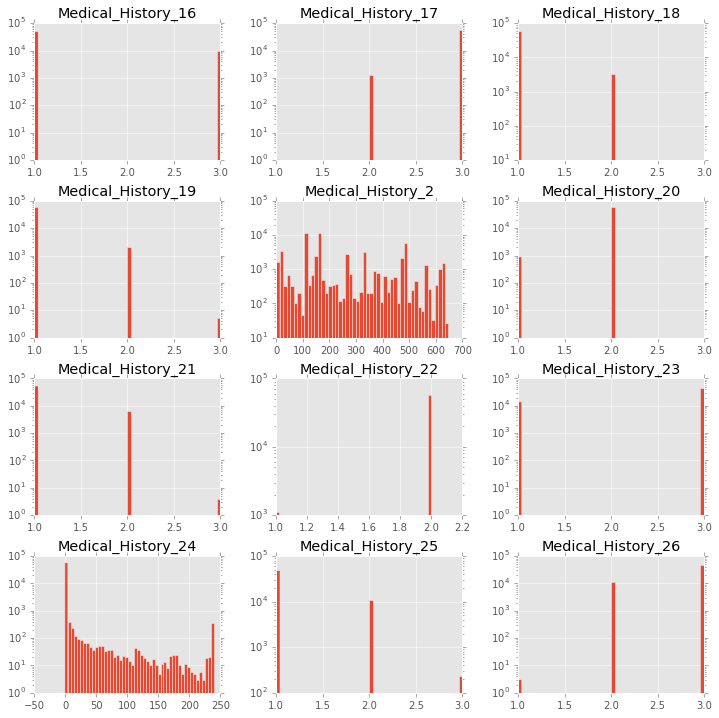

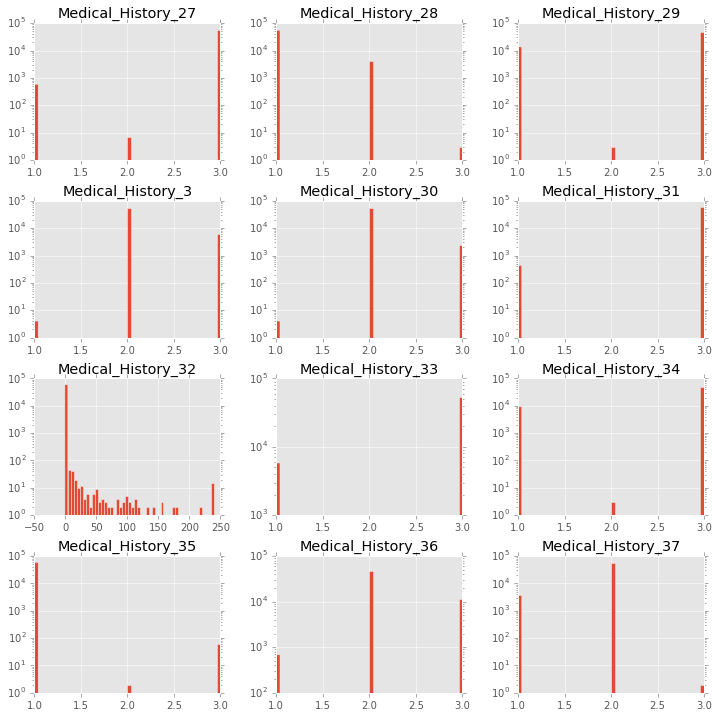

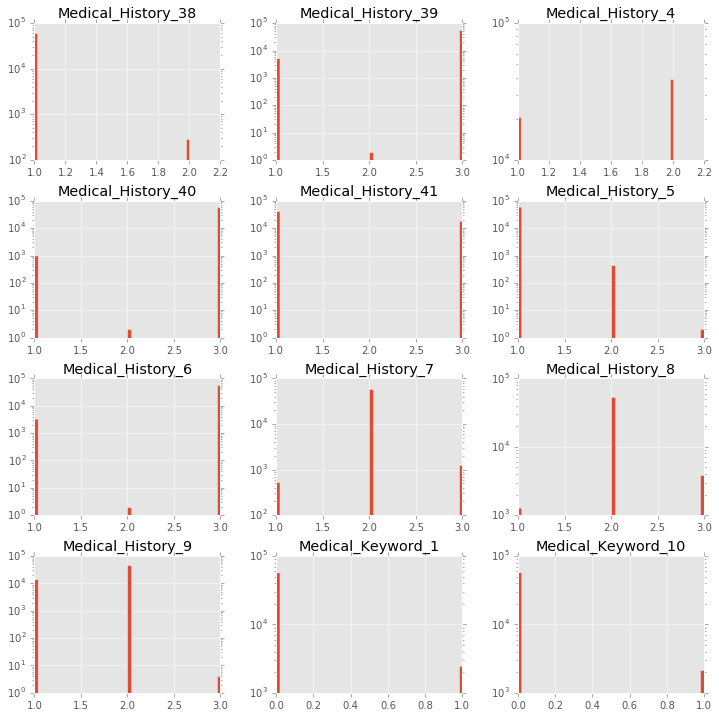

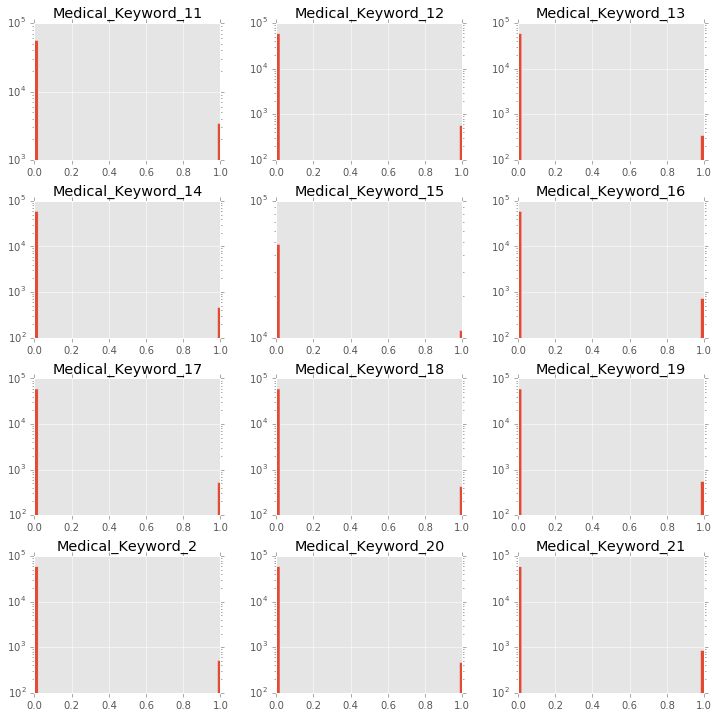

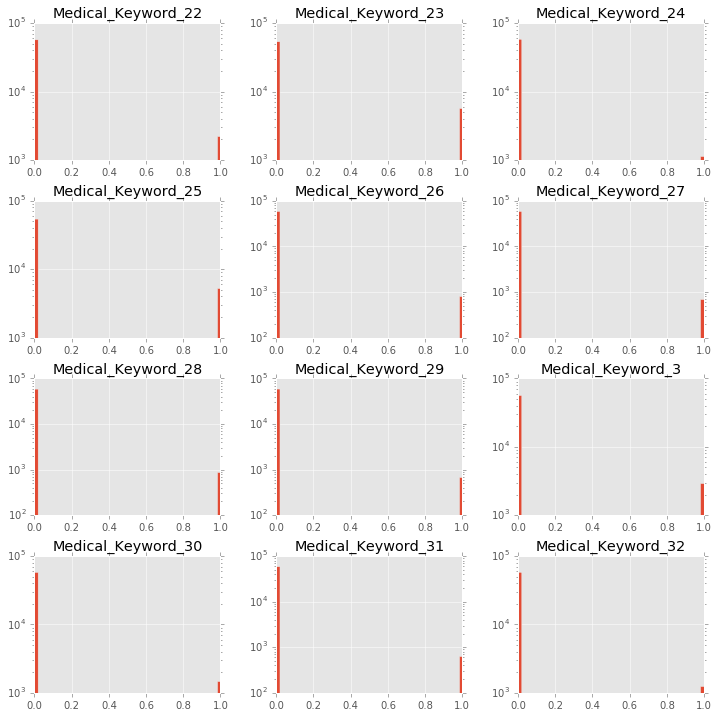

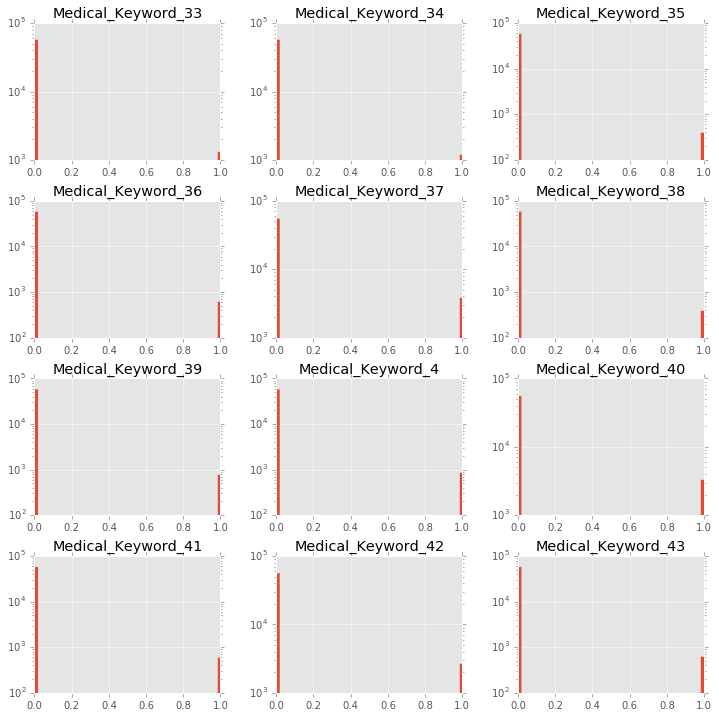

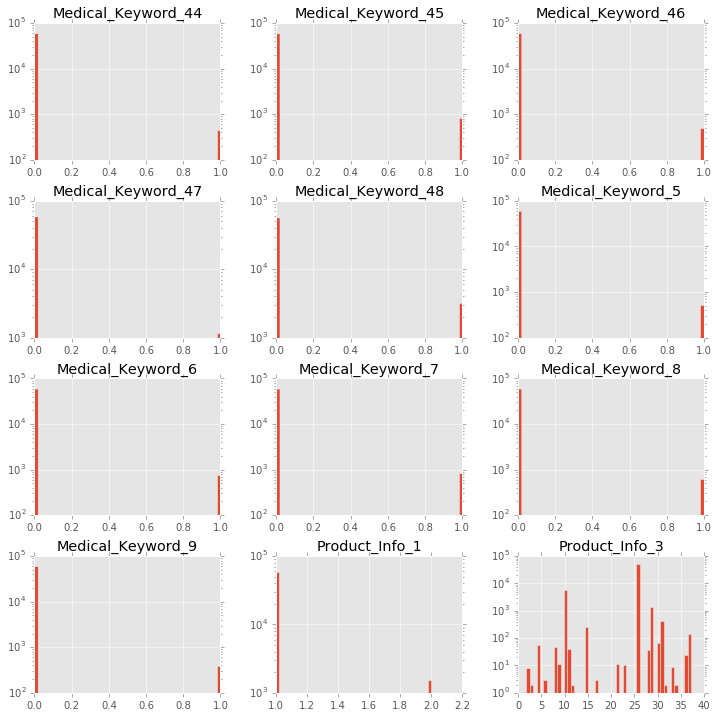

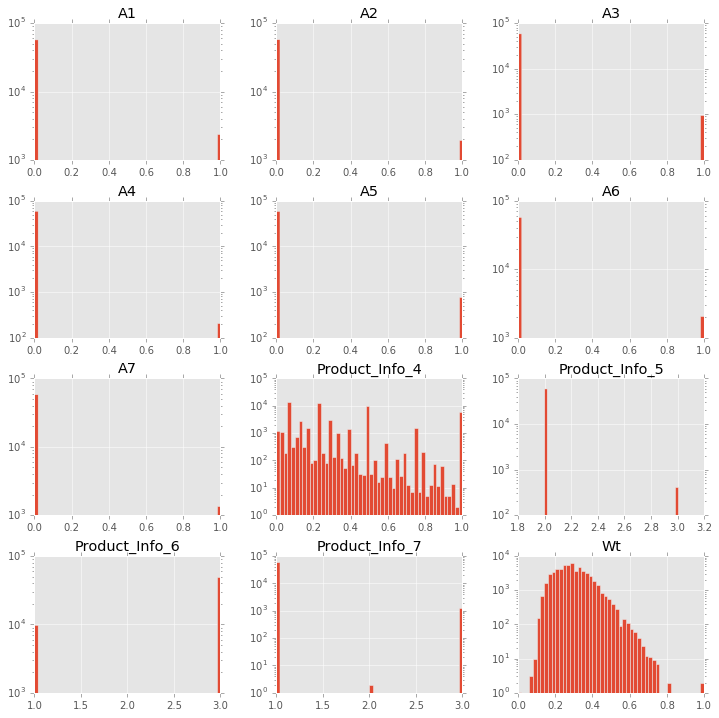

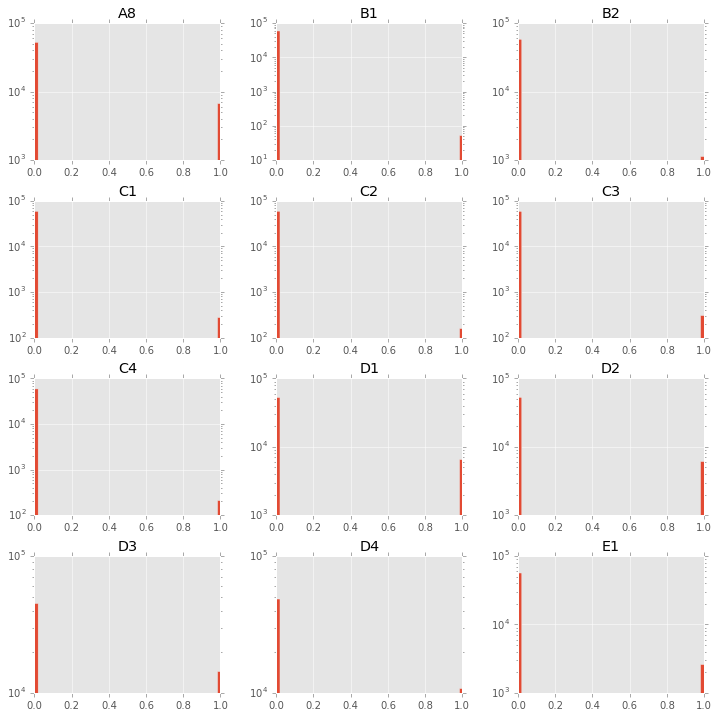

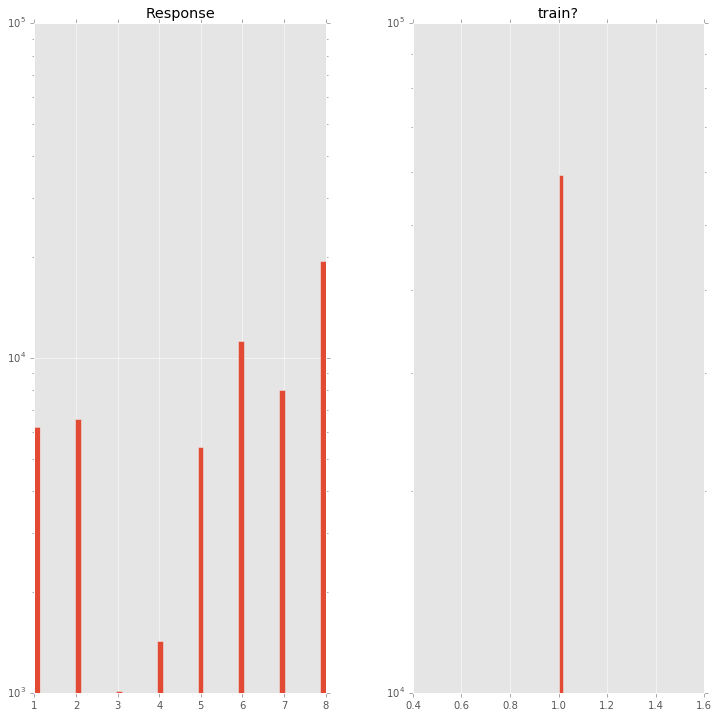

In [74]:
import itertools
import matplotlib
matplotlib.style.use('ggplot')

def grouper(n, iterable, fillvalue=None):
    "grouper(3, 'ABCDEFG', 'x') --> ABC DEF Gxx"
    args = [iter(iterable)] * n
    return itertools.zip_longest(*args, fillvalue=fillvalue)

it = grouper(12, train.columns)

for g in it:
    g = list(filter(lambda x: x is not None, g))
    ax = train[list(g)].hist(figsize=(12,12), bins=50)
    fig = ax[0,0].get_figure()
    for axis in ax.flat:
        axis.set_yscale('log')

    